<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_12_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第11回）**##

あれとこれが似ているとは、どのような尺度で何が似ているのか？
クラスター解析について学ぼう。まず、データ点集合が与えられたときのクラスタリング手法として**K-meansアルゴリズム**を紹介する。次に、潜在変数を用いた混合分布によるクラスタリング手法を学ぶ。その潜在変数モデルの最尤推定に、**Expectation-Maximization (EM)アルゴリズム**を紹介する。また、K-meansは、混合ガウス分布に対するEMアルゴリズムの非確率的極限として解釈できることを確認する。

###**K-means**###

一言でいうと、「データ点を、一番近いクラスター中心のクラスターに割り当てる」方法である。

$D$次元ユークリッド空間上の確率変数$x$の$N$個の観測点で構成されるデータ集合$\{x_1, ..., x_N\}$を$K$個のクラスターに分割することを考える。まず、$K$個の$D$次元ベクトル$\mu_k$($k=1,...,K$)を用意する。このベクトルの集合$\{\mu_k\}$が中心点を表す集合となる。次に、各データ点をクラスターに分けたときに、データ点と割り当てのクラスター中心点との二乗距離の総和が最小となるような割り当て方を考える。

データ点$x_n$に対し、クラスター$k$への割り当てを示す2値指示変数$r_{nk}\in \{0,1\}(k=1,..,K)$を定義する。データ点$x_n$がクラスター$k$に割り当てられる場合には$r_{nk}=1$、$j\neq k$のクラスターに対しては$r_{nj}=0$である。

目的関数$J$を次のように定義する
$$
J=\sum_{n=1}^N\sum_{k=1}^K r_{nk}\|x_n -\mu_k \|^2
$$
これは、各データ点から、その割り当てのクラスター中心点への二乗距離の和となっている。したがって、$J$を最小にする$\{r_{nk}\}$と$\{\mu_k\}$の集合を決定すれば、$K$個のクラスターへの割り当てが完了する。

K-meansでは、この最小化（最適化）を次の2ステップで行う。
まず、$\mu_k$の初期値を選び、$\mu_k$固定値として$r_{nk}$について$J$の最小化を行う。次に、$r_{nk}$を固定して$\mu_k$について$J$の最小化を行う。この2ステップ最小化が収束するまで繰り返す。

$r_{nk}$と$\mu_k$を更新する2ステップが、あとで見るEMアルゴリズムのEステップ(Expectation)とMステップ(Maximization)に対応する。

**\{$r_{nk}\}$の決定**

$r_{nk}$の決定は、各クラスター中心点への距離のうち、最小となるクラスターを割り当てればよい。
$$
r_{nk}=\left\{
\begin{matrix}
1 & k = argmin_j\|x_n-\mu_j \|^2 \\
0 & else
\end{matrix}
\right .
$$

**$\{\mu_k\}$の決定**

$r_{nk}$固定のまま$\mu_k$の最適化を考える。$J$の停留条件より
$$
\sum_{n=1}^Nr_{nk}(x_n - \mu_k) = 0
$$
よって
$$
\mu_k = \frac{\sum_{n=1}^Nr_{nk}x_n}{\sum_{n=1}^Nr_{nk}}
$$
この式は、実質的に、$k$番クラスターに割り当てられたデータ点の平均値（$D$次元平均ベクトル）を計算する式となる。

以上のデータ点の割り当てとクラスター中心点の計算を、再割り当てがなくなるまで繰り返す。



K= 1 cluster 0 x= 7.4782635156148425 y= 7.490096717211129


K= 2 cluster 0 x= 12.516498538120734 y= 12.437636672210344
K= 2 cluster 1 x= 2.440028493108946 y= 2.542556762211912


K= 3 cluster 0 x= 6.303203134125858 y= 6.556764302300551
K= 3 cluster 1 x= 13.516294496067745 y= 13.312565342922037
K= 3 cluster 2 x= 0.06981872611556017 y= 0.06784996094378415


K= 4 cluster 0 x= 15.058600787491425 y= 14.955879063205856
K= 4 cluster 1 x= 9.974396288750022 y= 9.919394281214856
K= 4 cluster 2 x= 4.893635323924111 y= 5.115437224513556
K= 4 cluster 3 x= -0.013578337706218288 y= -0.030323700089731318


K= 5 cluster 0 x= 4.4210714208355375 y= 4.760009458368461
K= 5 cluster 1 x= 0.39693843611336127 y= -0.7049209875084499
K= 5 cluster 2 x= 6.386006239964257 y= 6.458713477230084
K= 5 cluster 3 x= -0.4654917609865958 y= 0.7123002045476818
K= 5 cluster 4 x= 12.757821946802606 y= 12.661358058540063


K= 6 cluster 0 x= 5.707058087668676 y= 5.654182706480377
K= 6 cluster 1 x= 4.681575241436276 y= 4.255886

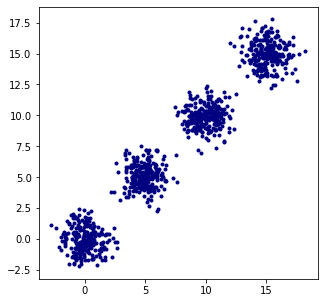

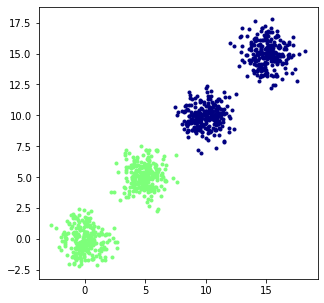

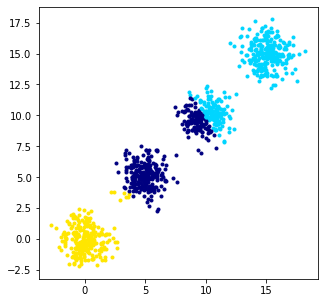

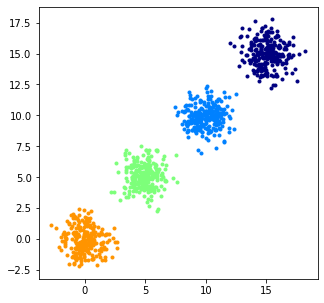

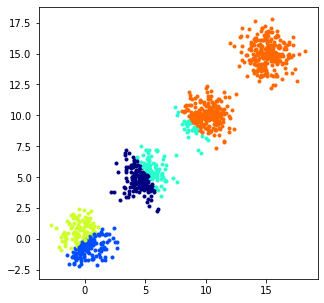

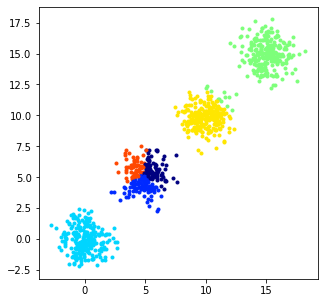

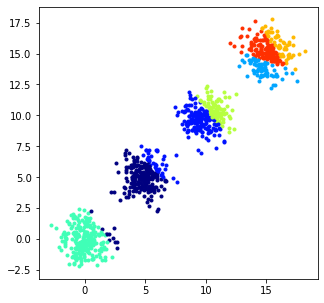

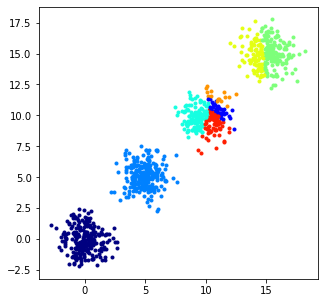

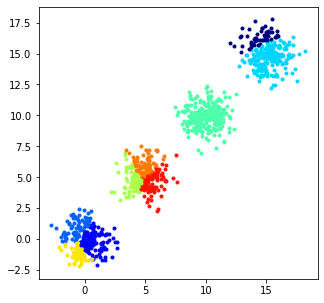

In [1]:
##
## K-means
## べた書き版
##
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt



class _data:
    def __init__(self, a, b,name):
        self.x = a
        self.y = b
        self.c = name
        self.n = 0

np.random.seed(0)

## 初期化

## 集団数
N = 4

data = []
mu = []
Js = []

## N個の集団を生成する。集団間の距離をsqrt(2)aとする。クラスター割り当てがどのようになるか確認してみよう。
a = 5
for i in range(1000):
  tmp = _data(np.random.normal(a*(i%N),1), np.random.normal(a*(i%N),1),-1)
  data.append(tmp)

def _initMu():

  for k in range(1):
    i = int(np.random.rand()*len(data))
    tmp = _data(0,0,0)
    mu.append(tmp)

  K = len(mu)
  for k in range(K):
    i = int(np.random.rand()*len(data))
    mu[k].x = data[i].x
    mu[k].y = data[i].y
    mu[k].c = k


def _plt():
  K = len(mu)
  fig = plt.figure(figsize = (5, 5))
  cmap = plt.get_cmap("jet")
  ax = fig.add_subplot(111)
  for item in data:
    ax.plot(item.x,item.y,'.',c=cmap(float(item.c/K)) )

def _Kmean():
  K = len(mu)
  ## E-step
  for i in range(len(data)):
    cls = -1
    dist_min = 1e+8
    for k in range(K):
      dist = np.square(data[i].x - mu[k].x)+np.square(data[i].y-mu[k].y)
      if dist_min > dist:
        cls = k
        dist_min = dist
    data[i].c = cls

  ## M-step
  for k in range(K):
    mu[k].x = 0
    mu[k].y = 0
    mu[k].n = 0

  for item in data:
    k = item.c
    mu[k].x += item.x
    mu[k].y += item.y
    mu[k].n += 1

  for k in range(K):
    if mu[k].n > 0:
      mu[k].x /= mu[k].n
      mu[k].y /= mu[k].n
  
  J = 0
  for item in data:
    k = item.c
    dist = np.square(item.x - mu[k].x)+np.square(item.y-mu[k].y)
    J += dist
  return J



for i in range(1,10):
  nTimes = 0
  dJ=1
  J = 0
  _initMu()
  while dJ > 1e-5:
    J_past = J
    J = _Kmean()
    dJ = J - J_past

  _plt()
  Js.append(J)

  print('\n')
  for item in mu:
    print('K=',len(mu),'cluster',item.c, 'x=',item.x, 'y=',item.y)

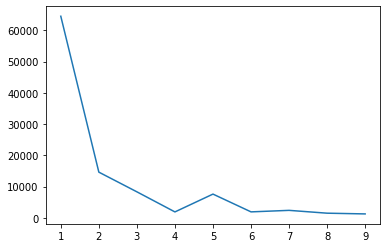

In [2]:
plt.plot(np.arange(1,10),Js)

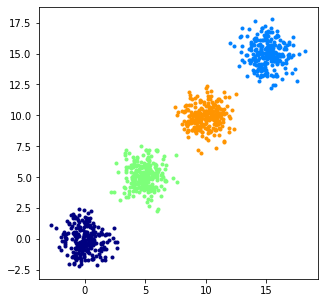

In [3]:
##
## scikit-learn
##
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
cmap = plt.get_cmap("jet")

arr = np.empty((0,2))
for item in data:
  arr = np.append(arr, np.array([[item.x, item.y]]), axis=0)

model_kmeans = KMeans(n_clusters=4, random_state=0)
pred=model_kmeans.fit(arr)
cluster = pred.predict(arr)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
for i in range(len(arr)):
  ax.plot(arr[i,0],arr[i,1],'.',c=cmap(cluster[i]/4.0))


###**EMアルゴリズム**###

K-meansでは、データ点$x_n$は対応するクラスター要素$k$から生成されたと捉えた。EMアルゴリズムでは、データ点$x_n$は各クラスター要素から確率的に生成される。すなわち、K-meansでは$r_{nk}\in \{0,1\}$と二値だったものが、EMアルゴリズムでは確率となる。このクラスター要素を表す潜在変数の集合を$Z$、データ集合を$X$と書くことにする。

同時分布$p(X,Z|\theta)$が与えられ、モデルパラメータ$\theta$で支配されているとする。EMアルゴリズムの目的は、対数尤度関数$\log p(X|\theta)$を$\theta$について最大化することである。

$$
\log p(X|\theta) = \log \{\sum_Z p(X,Z|\theta) \}
$$
$\{X,Z\}$の組を完全データ集合という。
実際には、不完全データ$X$だけが与えられる。潜在変数$Z$についての知識は、$X$と$\theta$が与えられたときに$Z$であった確率、すなわち、事後確率分布$p(Z|X,\theta)$だけである。この事後確率分布を決めるのがEステップ、そのもとで、完全データ対数尤度$\log p(X,Z|\theta)$の期待値を最大化するのがMステップである。
アルゴリズムを以下に記す。

**アルゴリズム**

適当なパラメータ初期値$\theta^{old}$を選ぶ。
1.   Eステップ： $p(Z|X,\theta^{old})$を計算する
2.   Mステップ： $\theta^{new}$を計算する
$$
\theta^{new}=argmax_\theta Q(\theta,\theta^{old})\\
Q(\theta,\theta^{old})=\sum_{Z}p(Z|X,\theta^{old})\log p(X,Z|\theta)
$$

１と２を収束するまで繰り返す。

**解説**

潜在変数について分布$q(Z)$を導入すると、次のように目的の対数尤度関数の下界を示せる。

$$
\begin{matrix}
\log p(X|\theta) &=& \log\{\sum_Z p(X,Z|\theta) \}\\ 
&=& \log \sum_Z q(Z)\frac{p(X,Z|\theta)}{q(Z)}\\ 
&\geq& l(q,\theta)
\end{matrix}
$$
最後の変形でJensen不等式$(E[\log \cdot] \geq \log E[\cdot]$ )を使った。

ここで、
$$
l(q,\theta) = \sum_Zq(Z)\log\frac{p(X,Z|\theta)}{q(Z)}
$$
と定義した。

次に、
$$
p(X,Z|\theta) = p(Z|X,\theta)p(X|\theta)
$$
であるから
$$
l(q,\theta)=\sum_Z q(Z)\log p(Z|X,\theta)p(x|\theta) -\sum_Z q(Z) \log q(Z)\\ 
= \log p(x|\theta) - D_{KL}(q||p)
$$
ここで
$$
D_{KL}(q||p)=-\sum_Zq(z)\log\frac{p(Z|X,\theta)}{q(Z)}
$$
である。
よって、目的の対数尤度関数は
$$
\log p(X|\theta) = l(q,\theta) + D_{KL}(q||p)
$$
と分解できることが分かる。

EMアルゴリズムでは、まず、Eステップで、$l(q|\theta^{old})$を$q(Z)$について最大化する。いつでも$D_{KL}\geq 0$であるから、分解の式により、$l(q|\theta^{old})$の最大化は$D_{KL}=0$で実現できることが分かる。したがって、$q(Z)=P(Z|X,\theta^{old})$である。

次に、Mステップで、分布$q(Z)$を固定し、下界$l(q|\theta)$を$\theta$について最大化し、新しい$\theta^{new}$を得る。これにより、下界$l(q|\theta)$が増加する。

分布$q(Z)$は固定されていたので、新しい$\theta^{new}$による事後分布$p(Z|X,\theta^{new})$とは$D_{KL}(q||p)>0$である。そこで、$q(Z)$を新しい事後分布に更新することで、下界を再び押し上げる。これらを繰り返すことで、目的の対数尤度関数$\log p(X|\theta)$は逐次的に増大する。

また、EMアルゴリズムでは、対数尤度関数$\log p(X|\theta)$を計算できるので、**クラスターの数をAICで選択する**ことができる。

####**(例)混合ガウス分布**####

混合ガウス分布とは、ガウス分布の線形和の分布である。
$$
p(x) = \sum_{k=1}^K\pi_k N(x|\mu_k,\Sigma_k)\\
\sum_{k=1}^K \pi_k = 1
$$

ここからは、上式の混合ガウス分布を潜在変数の導入により、解釈しなおす。
まず、$K$個の成分からなる潜在変数$Z=\{z_1,..z_k..,z_K\}$とし、$z_k\in \{0,1\}$の二値をとる。このとき、どれか1つの成分が、確率$\pi_k$で値1となり、ほかは0とする。（$\sum_k z_k = 1$）。すなわち、$Z$の状態は次の確率分布に従う。
$$
P(Z) = \Pi_{k=1}^K \pi_k^{z_k}
$$
$Z$の値が$z_k=1$と与えられたときに、$x$の条件付き分布は次のガウス分布であるとする。
$$
p(x|z_k=1)=N(x|\mu_k,\Sigma_k)
$$
これを用いて、
$$
p(x|Z) = \Pi_{k=1}^K \left[ N(x|\mu_k,\Sigma_k)\right]^{z_k}
$$
である。

同時分布$p(x,Z)=p(x|Z)p(Z)$より
$$
p(x,Z) = \Pi_{k=1}^K \pi_k^{z_k}\left[ N(x|\mu_k,\Sigma_k)\right]^{z_k}
$$
したがって、$x$の周辺分布は
$$
p(x) = \sum_Z p(x,Z) = \sum_{k=1}^K \pi_k  N(x|\mu_k,\Sigma_k)
$$
ここで、$\sum_Z$は$\sum_kz_k=1$を満たす全状態の和である。
このように、混合ガウス分布は潜在変数とデータ$x$の同時分布を経由して導くことが出来る。この点が重要となる。


では、混合ガウス分布をEMアルゴリズムに乗せていこう。

まず、Eステップにおいて、「現在のパラメータ値$\theta^{old}$を使って$p(Z|X,\theta^{old})$を計算する」ために、データ$x_n$とパラメータ値$\theta^{old}$が与えられたときに、$z_{nk}=1$となる事後分布を求める。

ベイズの定理から
$$
p(z_{nk}=1|x_n,\theta_k^{old}) = \frac{p(x_n|z_{nk}=1,\theta_k^{old})p(z_{nk}=1)}{p(x_n|\theta^{old})}
$$
ここで、
$$
p(x_n|\theta^{old}) = \sum_{j=1}^K p(x_n|z_{nj}=1,\theta_j^{old})p(z_{nj}=1)
$$
である。$z_{nk}=1$の事前分布は、
$$
P(Z=\{0,0,..z_{nk}=1..,0\}) = \pi_{k}
$$
であり、
$$
p(x_n|z_{nk}=1,\theta_k^{old})=N(x_n|\mu_k^{old},\Sigma_k^{old})
$$
であるから、結局、
$$
p(z_{nk}=1|x_n,\theta_k^{old}) = \frac{\pi_{k}N(x_n|\mu_k^{old},\Sigma_k^{old})}{\sum_{j=1}^{K}\pi_{j}N(x_n|\mu_j^{old},\Sigma_j^{old}) }
$$
である。
したがって、
$$
p(Z|X,\theta^{old}) = \Pi_n \Pi_k \left[p(z_{nk}=1|x_n,\theta^{old}) \right]^{z_{nk}}
$$

次に、Mステップにおいて、「分布$q(Z)$を固定し、$Q(\theta,\theta^{old})$を最大化するパラメータ値$\theta^{new}$を求める」であった。
$Q$は結局のところ、対数尤度関数$\log p(X,Z|\theta)$を、Eステップでもとめた事後分布$p(Z|X,\theta^{old})$で期待値をとったものである。

$$
Q(\theta, \theta^{old}) = \sum_{\{z_{nk}\}} p(Z|X,\theta^{old})  \log \Pi_n \Pi_{k=1}^K \pi_k^{z_{nk}}\left[ N(x_n|\mu_k,\Sigma_k)\right]^{z_{nk}}\\ 
=\sum_{\{z_{nk}\}}p(Z|X,\theta^{old})\sum_n\sum_k z_{nk}\{ \log\pi_k + \log N(x_n|\mu_k,\Sigma_k) \}\\ 
=\sum_n \sum_k \gamma (z_{nk})\{ \log\pi_k + \log N(x_n|\mu_k,\Sigma_k) \}
$$
ここで、$z_{nk}$の期待値$E[z_{nk}]=\gamma (z_{nk})$とした。
そして、この期待値は次のように計算できる。
$$
E[z_{nk}] = \sum_{ \{z_{nk}\} }p(Z|x_n,\theta_k^{old}) z_{nk}\\ 
=\sum_{ \{z_{nk}\} }z_{nk}\Pi_{k'} \left [\frac{\pi_{k'}N(x_n|\mu_{k'}^{old},\Sigma_{k'}^{old})}{\sum_{j=1}^{K}\pi_{j}N(x_n|\mu_j^{old},\Sigma_j^{old}) }\right]^{z_{nk'}}\\ 
=\frac{\pi_{k}N(x_n|\mu_k^{old},\Sigma_k^{old})}{\sum_{j=1}^{K}\pi_{j}N(x_n|\mu_j^{old},\Sigma_j^{old}) }
$$
とどのつまり、$z_{nk}=1$である確率である。データ$x_n$が生成される確率のうち、要素$k$が負担する確率であるので、負担率と呼ばれる。

さて、$Q$を最大化するが、$\sum_k \pi_k = 1$の制約条件があるので、ラグランジュ未定係数法を使って、次の式の最大化として扱う。
$$
Q'(\theta,\theta^{old})=Q(\theta,\theta^{old}) - \lambda(\sum_{k=1}^K\pi_k - 1)
$$
パラメータ$\mu_k,\Sigma_k, \pi_k$について、それぞれ、極値条件から以下を得る。
$$
\mu_k^{new} = \frac{1}{N_k}\sum_n\gamma (z_{nk})x_n
$$
$$
\Sigma_k = \frac{1}{N_k}\sum_n \gamma(z_{nk})(x_n - \mu_k)(x_n-\mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
ただし、
$$
N_k = \sum_n \gamma(z_{nk})
$$
と置いた。


**まとめると**

1.   適当に$\mu_k$、分散$\sigma_k$、混合係数$\pi_k$を初期化する。例えば、k-meansで分けて、これらの値を計算する。そして、対数尤度関数の初期値を計算する。
2.   Eステップ：現在のパラメータ値を使って、負担率$\gamma(z_{nk})$を計算する。
3.   Mステップ：Eステップで更新された負担率$\gamma(z_{nk})$を使って、$\mu_k^{new},\Sigma_k^{new}, \pi_k^{new}$を計算する。
4.  Mステップの更新で、パラメータ値あるいは対数尤度関数$\log p(X|\theta)$の値の変化が閾値以下かを判定し、まだ閾値以上の変化であれば、2に戻る。


In [4]:
##
## EM algorithm
## scikit-learn
##

import numpy as np
import itertools


from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

from sklearn import mixture

# Number of samples per component
n_samples = len(arr)

# Generate random sample, two components
np.random.seed(0)
#C = np.array([[0.0, -0.1], [1.7, 0.4]])
#X = np.r_[
#    arr[:,0],
#    arr[:,1],
#]
X = np.empty((0,2))
for item in data:
  X = np.append(arr, np.array([[item.x, item.y]]), axis=0)

lowest_aic = np.infty
aic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        
        aic.append(gmm.aic(X))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

aic = np.array(aic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm

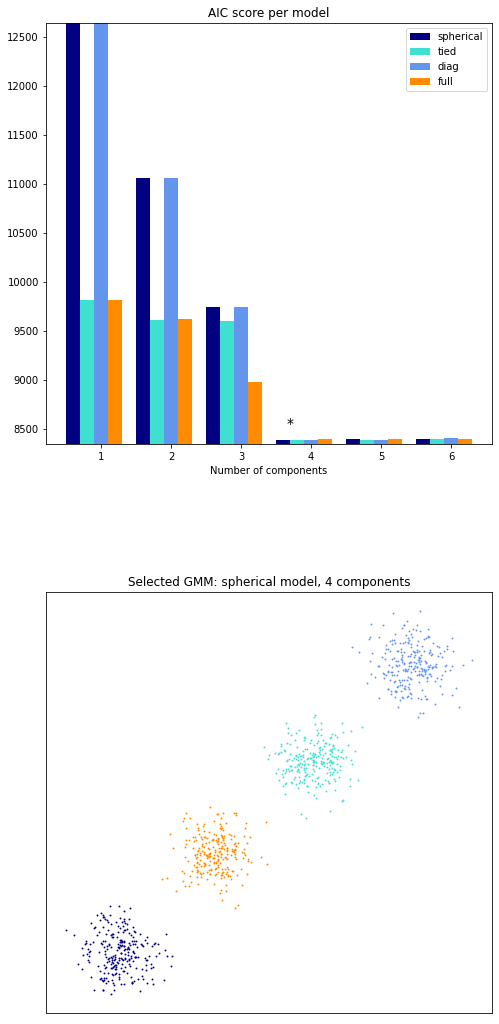

In [5]:
# Plot the AIC scores
bars = []
plt.figure(figsize=(8, 16))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            aic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - 0.01 * aic.max(), aic.max()])
plt.title("AIC score per model")
xpos = (
    np.mod(aic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(aic.argmin() / len(n_components_range))
)
plt.text(xpos, aic.min() * 0.97 + 0.03 * aic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)

for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    if not np.any(Y_ == i):
        continue

    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

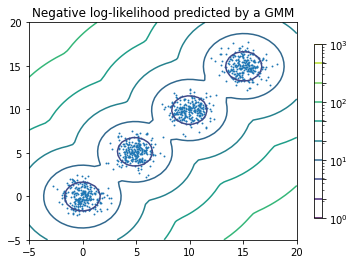

In [6]:
# display predicted scores by the model as a contour plot
x = np.linspace(-5.0, 20.0)
y = np.linspace(-5.0, 20.0)
mX, mY = np.meshgrid(x, y)
XX = np.array([mX.ravel(), mY.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(mX.shape)

CS = plt.contour(
    mX, mY, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(arr[:, 0], arr[:, 1], 0.8)

plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()